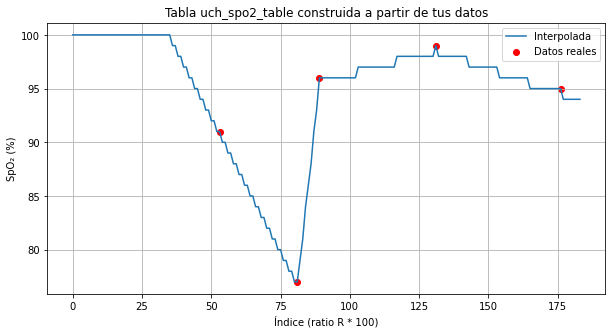

In [7]:
import pandas as pd
import os
import re
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

ruta = "C:/Users/Elena/Desktop/GitHub/TFG-Elena-Ruiz/Datos/Procesados"
archivos = [f for f in os.listdir(ruta) if f.endswith(".csv")]

ratios_dict = defaultdict(list)

for archivo in archivos:
    match = re.search(r'(\d+)_\d+\.csv', archivo)  # Extrae el SpO2 externo
    if match:
        spo2_ext = int(match.group(1))
        try:
            df = pd.read_csv(os.path.join(ruta, archivo))
            ir = df["IR"] - df["AMB_IR"]
            red = df["RED"] - df["AMB_RED"]

            ac_ir = ir.max() - ir.min()
            dc_ir = ir.mean()
            ac_red = red.max() - red.min()
            dc_red = red.mean()

            if all(val > 0 for val in [ac_ir, dc_ir, ac_red, dc_red]):
                ratio = (ac_red / dc_red) / (ac_ir / dc_ir)
                index = int(ratio * 100)
                if 0 <= index < 184:
                    ratios_dict[index].append(spo2_ext)
        except Exception as e:
            print(f"{archivo}: ERROR {e}")

# Crear tabla a partir del promedio por índice
tabla_spo2 = [0] * 184
for idx in range(184):
    if ratios_dict[idx]:
        tabla_spo2[idx] = int(np.mean(ratios_dict[idx]))

# Interpolación para rellenar huecos
x_known = [i for i, val in enumerate(tabla_spo2) if val > 0]
y_known = [val for val in tabla_spo2 if val > 0]

interp_func = interp1d(x_known, y_known, kind='linear', fill_value="extrapolate")
tabla_spo2_interp = [int(np.clip(interp_func(i), 70, 100)) for i in range(184)]

# Visualizar la tabla construida
plt.figure(figsize=(10, 5))
plt.plot(tabla_spo2_interp, label="Interpolada")
plt.scatter(x_known, y_known, color='red', label="Datos reales")
plt.xlabel("Índice (ratio R * 100)")
plt.ylabel("SpO₂ (%)")
plt.title("Tabla uch_spo2_table construida a partir de tus datos")
plt.grid(True)
plt.legend()
plt.show()


In [8]:
def estimar_spo2(ratio, tabla):
    index = int(ratio * 100)
    index = np.clip(index, 0, len(tabla) - 1)
    return tabla[index]

print("\n--- Estimación de SpO₂ usando tu propia tabla ---\n")
for archivo in archivos:
    try:
        df = pd.read_csv(os.path.join(ruta, archivo))
        ir = df["IR"] - df["AMB_IR"]
        red = df["RED"] - df["AMB_RED"]

        ac_ir = ir.max() - ir.min()
        dc_ir = ir.mean()
        ac_red = red.max() - red.min()
        dc_red = red.mean()

        if all(val > 0 for val in [ac_ir, dc_ir, ac_red, dc_red]):
            ratio = (ac_red / dc_red) / (ac_ir / dc_ir)
            spo2_estimado = estimar_spo2(ratio, tabla_spo2_interp)
            print(f"{archivo:40s} → R = {ratio:.3f} → SpO₂ estimado = {spo2_estimado}%")
        else:
            print(f"{archivo:40s} → Señal no válida")
    except Exception as e:
        print(f"{archivo:40s} → ERROR: {e}")



--- Estimación de SpO₂ usando tu propia tabla ---

raw_data_91_91.csv                       → R = 0.534 → SpO₂ estimado = 91%
raw_data_92_76.csv                       → R = 11.015 → SpO₂ estimado = 94%
raw_data_93_100.csv                      → Señal no válida
raw_data_95_77_2.csv                     → R = 0.811 → SpO₂ estimado = 77%
raw_data_95_80.csv                       → R = 2.246 → SpO₂ estimado = 94%
raw_data_95_81_papa.csv                  → R = 0.626 → SpO₂ estimado = 86%
raw_data_95_99.csv                       → R = 1.770 → SpO₂ estimado = 95%
raw_data_96_69.csv                       → R = 0.895 → SpO₂ estimado = 96%
raw_data_98_81.csv                       → R = 4.006 → SpO₂ estimado = 94%
raw_data_99_75.csv                       → R = 2.311 → SpO₂ estimado = 94%
raw_data_99_91.csv                       → R = 1.311 → SpO₂ estimado = 99%


In [ ]:
# Cargar el archivo CSV
df = pd.read_csv("/mnt/data/raw_data_95_77_2.csv")

# Corregimos por luz ambiental
df["IR_corr"] = df["IR"] - df["AMB_IR"]

# Convertir tiempo a segundos
df["Tiempo_s"] = df["Tiempo (ms)"] / 1000

# Recorte de una ventana de 10 segundos para mejor visualización
# Suponiendo que la frecuencia de muestreo es de 60 Hz
ventana_segundos = 10
fs = 60
n_muestras = ventana_segundos * fs
df_recorte = df.iloc[:n_muestras]

# Graficar solo esa ventana
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(df_recorte["Tiempo_s"], df_recorte["IR_corr"], label="IR corregido")
plt.title("Señal PPG (IR corregido) - Ventana de 10 segundos")
plt.xlabel("Tiempo (s)")
plt.ylabel("Intensidad")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
